# GSE153170
## Xiaonan Wang
## 17Aug2022

In [1]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
from os import listdir
from os.path import isfile, join
import re
import anndata
import seaborn as sns

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)

scanpy==1.7.1 anndata==0.7.8 umap==0.5.1 numpy==1.19.5 scipy==1.5.4 pandas==1.1.5 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.6


# Data in

In [2]:
FileDir = '/nfs01data1/Groups/Wangxiaonan/share/rev_MI/GSE153170/'

In [3]:
# sorted mCherry+
meta = pd.DataFrame([['GSM4635175', '4-18m', 'adult', 'Injured', '7', 'Tg(tcf21:mCherry)', 'ventricle', 'GSE153170', 'Epicardial cells', 'WT', 'Danio rerio', 'mixed', 'Bakker'],
                   ['GSM4635176', '4-18m', 'adult', 'Injured', '7', 'Tg(tcf21:mCherry)', 'ventricle', 'GSE153170', 'Epicardial cells', 'WT', 'Danio rerio', 'mixed', 'Bakker'],
                   ['GSM4635177', '4-18m', 'adult', 'Injured', '7', 'Tg(tcf21:mCherry)', 'ventricle', 'GSE153170', 'Epicardial cells', 'prrx1b-/-', 'Danio rerio', 'mixed', 'Bakker'],
                   ['GSM4635178', '4-18m', 'adult', 'Injured', '7', 'Tg(tcf21:mCherry)', 'ventricle', 'GSE153170', 'Epicardial cells', 'prrx1b-/-', 'Danio rerio', 'mixed', 'Bakker']
                    ], columns = ['Index', 'Age', 'Development_stage', 'Condition', 'Day', 'Strain', 'Tissue', 'StudyID', 'CellType', 'Genotype', 'Organism', 'Gender', 'Author'])

In [4]:
Files = [x for x in listdir(FileDir) if 'GSM' in x]
print(Files)

['GSM4635175_HUB-DB-009_H3HCLBGXC_S1_R2.TranscriptCounts.tsv', 'GSM4635176_HUB-DB-010_H3HCLBGXC_S2_R2.TranscriptCounts.tsv', 'GSM4635177_HUB-DB-011_H3HCLBGXC_S3_R2.TranscriptCounts.tsv', 'GSM4635178_HUB-DB-012_H3HCLBGXC_S4_R2.TranscriptCounts.tsv']


In [40]:
CN = pd.read_csv('/nfs01data1/Groups/Wangxiaonan/share/rev_MI/GSE153170/GSE153170_cel-seq2_barcodes.csv', header=None, delimiter='\t')

In [41]:
CN = pd.DataFrame([x.split('\t') for x in CN[0]])
CN = CN.set_index(0)

In [42]:
CN.head()

,1
0,
1,CGTCTAAT
2,AGACTCGT
3,GCACGTCA
4,TCAACGAC
5,ATTTAGCG


In [43]:
GN = pd.read_csv('../drerio_mmusculus.txt', delimiter='\t', index_col=0)

In [44]:
GN.head()

,external_gene_name,mmusculus_homolog_ensembl_gene,mmusculus_homolog_associated_gene_name
ensembl_gene_id,,,
ENSDARG00000063344,fam162a,ENSMUSG00000019909,Fam162b
ENSDARG00000097685,si:ch211-235i11.3,NaN,NaN
ENSDARG00000036008,caly,ENSMUSG00000025468,Caly
ENSDARG00000069301,tmem177,ENSMUSG00000036975,Tmem177
ENSDARG00000104901,ostc,ENSMUSG00000041084,Ostc


In [45]:
adata = []
for idx, row in meta.iterrows():
    FN = [x for x in Files if row['Index'] in x][0]
    print(FN)
    adata_sub = pd.read_csv(FileDir+Files[idx], delimiter='\t', index_col=0)
    adata_sub = anndata.AnnData(X=adata_sub.T)
    adata_sub = adata_sub[:, [x for x in adata_sub.var_names if 'ERCC' not in x]].copy()
    adata_sub.obs_names = [x.lstrip('0') for x in adata_sub.obs_names]
    adata_sub.obs_names = CN.loc[adata_sub.obs_names,1].values
    vn = np.unique(np.intersect1d(adata_sub.var_names, GN.index))
    gn_sub = GN.loc[vn, :].copy()
    adata_sub = adata_sub[:,gn_sub.index].copy()
    adata_sub.var = gn_sub
    adata_sub.var['ensembl_gene_id'] = adata_sub.var_names
    adata_sub.var_names = [str(x) for x in adata_sub.var.external_gene_name]
    print(np.array(adata_sub.var_names))
    adata_sub.var_names_make_unique()
    adata_sub.obs['Index'] = row['Index']
    adata_sub.obs['Age'] = row['Age']
    adata_sub.obs['Development_stage'] = row['Development_stage']
    adata_sub.obs['Condition'] = row['Condition']
    adata_sub.obs['Day'] = row['Day']
    adata_sub.obs['Strain'] = row['Strain']
    adata_sub.obs['Tissue'] = row['Tissue']
    adata_sub.obs['StudyID'] = row['StudyID']
    adata_sub.obs['CellType'] = row['CellType']
    adata_sub.obs['Genotype'] = row['Genotype']
    adata_sub.obs['Organism'] = row['Organism']
    adata_sub.obs['Gender'] = row['Gender']
    adata_sub.obs['Author'] = row['Author']
    
    adata.append(adata_sub)
    del adata_sub

GSM4635175_HUB-DB-009_H3HCLBGXC_S1_R2.TranscriptCounts.tsv


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


['slc35a5' 'ccdc80' 'nrf1' ... 'si:ch73-127m5.2' 'si:dkey-287g12.6'
 'BX279523.1']
GSM4635176_HUB-DB-010_H3HCLBGXC_S2_R2.TranscriptCounts.tsv


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


['slc35a5' 'ccdc80' 'nrf1' ... 'si:ch211-277e21.1' 'si:dkey-287g12.6'
 'BX279523.1']
GSM4635177_HUB-DB-011_H3HCLBGXC_S3_R2.TranscriptCounts.tsv


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


['slc35a5' 'ccdc80' 'nrf1' ... 'si:ch73-127m5.2' 'si:dkey-287g12.6'
 'BX279523.1']
GSM4635178_HUB-DB-012_H3HCLBGXC_S4_R2.TranscriptCounts.tsv


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


['slc35a5' 'ccdc80' 'nrf1' ... 'si:ch73-127m5.2' 'si:ch211-277e21.1'
 'si:dkey-287g12.6']


In [48]:
adata

[AnnData object with n_obs × n_vars = 384 × 17036
     obs: 'Index', 'Age', 'Development_stage', 'Condition', 'Day', 'Strain', 'Tissue', 'StudyID', 'CellType', 'Genotype', 'Organism', 'Gender', 'Author'
     var: 'external_gene_name', 'mmusculus_homolog_ensembl_gene', 'mmusculus_homolog_associated_gene_name', 'ensembl_gene_id',
 AnnData object with n_obs × n_vars = 384 × 16009
     obs: 'Index', 'Age', 'Development_stage', 'Condition', 'Day', 'Strain', 'Tissue', 'StudyID', 'CellType', 'Genotype', 'Organism', 'Gender', 'Author'
     var: 'external_gene_name', 'mmusculus_homolog_ensembl_gene', 'mmusculus_homolog_associated_gene_name', 'ensembl_gene_id',
 AnnData object with n_obs × n_vars = 384 × 16947
     obs: 'Index', 'Age', 'Development_stage', 'Condition', 'Day', 'Strain', 'Tissue', 'StudyID', 'CellType', 'Genotype', 'Organism', 'Gender', 'Author'
     var: 'external_gene_name', 'mmusculus_homolog_ensembl_gene', 'mmusculus_homolog_associated_gene_name', 'ensembl_gene_id',
 AnnData o

# QC

In [49]:
[x for x in adata[0].var_names if x.startswith('mt-')]

['mt-nd1',
 'mt-nd2',
 'mt-co1',
 'mt-co2',
 'mt-atp8',
 'mt-atp6',
 'mt-co3',
 'mt-nd3',
 'mt-nd4l',
 'mt-nd4',
 'mt-nd5',
 'mt-nd6',
 'mt-cyb']

In [50]:
for i in range(len(adata)):
    adata[i].var['mt'] = adata[i].var_names.str.startswith('mt-') 
    sc.pp.calculate_qc_metrics(adata[i], qc_vars=['mt'], inplace=True)

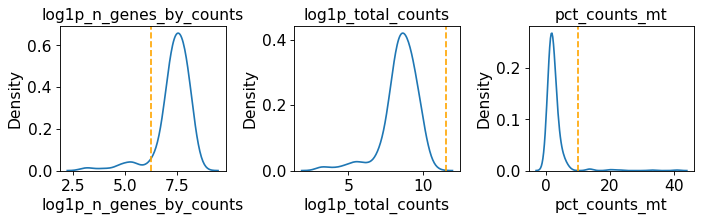

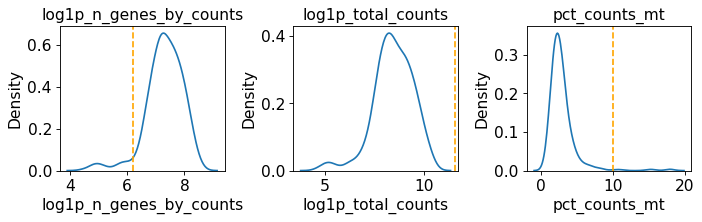

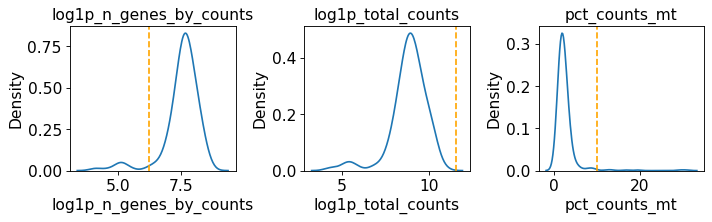

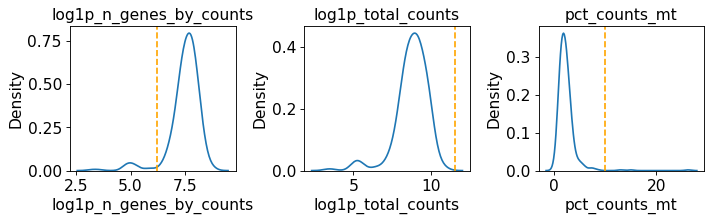

In [53]:
cutoffs = [[500,100000, np.exp(10)],
           [500,100000, np.exp(10)],
           [500,100000, np.exp(10)],
           [500,100000, np.exp(10)],
           ]
for i in range(len(adata)):
    obs_terms = ['log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_mt']
    fig,ax = plt.subplots(1,3, figsize=(9,3))
    for j in range(len(obs_terms)):
        sns.kdeplot(adata[i].obs[obs_terms[j]], ax=ax[j])
        ax[j].grid(False)
        ax[j].set_title(obs_terms[j])
        ax[j].axvline(np.log1p(cutoffs[i][j]), c='orange', linestyle='--')
    plt.tight_layout()

In [54]:
for i in range(len(adata)):
    sc.pp.filter_cells(adata[i], min_genes=cutoffs[i][0])
    #sc.pp.filter_genes(adata[i], min_cells=1)
    adata[i] = adata[i][(adata[i].obs['total_counts'] <= cutoffs[i][1]) & (adata[i].obs['pct_counts_mt'] <= np.log(cutoffs[i][2])), :].copy()
    print(adata[i].obs['Condition'].value_counts().sort_index())

filtered out 29 cells that have less than 500 genes expressed
filtered out 20 cells that have less than 500 genes expressed
filtered out 19 cells that have less than 500 genes expressed
filtered out 18 cells that have less than 500 genes expressed


Injured    352
Name: Condition, dtype: int64
Injured    362
Name: Condition, dtype: int64
Injured    361
Name: Condition, dtype: int64
Injured    363
Name: Condition, dtype: int64


In [55]:
for i in range(len(adata)):
    print(adata[i].shape)

(352, 17036)
(362, 16009)
(361, 16947)
(363, 16885)


In [56]:
#combine and save the raw counts
adata1 = anndata.AnnData.concatenate(*adata) #, join='outer', fill_value=0

In [57]:
adata1.shape

(1438, 14217)

In [58]:
sc.pp.filter_genes(adata1, min_cells=1)

In [59]:
adata1.write('./write/GSE153170_raw.h5ad')

... storing 'Index' as categorical
... storing 'Age' as categorical
... storing 'Development_stage' as categorical
... storing 'Condition' as categorical
... storing 'Day' as categorical
... storing 'Strain' as categorical
... storing 'Tissue' as categorical
... storing 'StudyID' as categorical
... storing 'CellType' as categorical
... storing 'Genotype' as categorical
... storing 'Organism' as categorical
... storing 'Gender' as categorical
... storing 'Author' as categorical
... storing 'external_gene_name-0' as categorical
... storing 'mmusculus_homolog_ensembl_gene-0' as categorical
... storing 'mmusculus_homolog_associated_gene_name-0' as categorical
... storing 'ensembl_gene_id-0' as categorical
... storing 'external_gene_name-1' as categorical
... storing 'mmusculus_homolog_ensembl_gene-1' as categorical
... storing 'mmusculus_homolog_associated_gene_name-1' as categorical
... storing 'ensembl_gene_id-1' as categorical
... storing 'external_gene_name-2' as categorical
... storin

# Normalisation

In [60]:
adata = sc.read('./write/GSE153170_raw.h5ad')

In [61]:
print(adata.shape)

(1438, 14217)


In [62]:
# normalisation
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [63]:
# log counts
sc.pp.log1p(adata)

In [64]:
adata.raw = adata

In [65]:
print(adata.shape)

(1438, 14217)


In [66]:
adata.write('./write/GSE153170_lognorm.h5ad')

# Cell Cycle Assignment

In [67]:
adata = sc.read('./write/GSE153170_lognorm.h5ad')

In [68]:
print(adata.shape)

(1438, 14217)


In [69]:
cell_cycle_genes = [x.strip()[0].upper()+x.strip()[1:].lower() for x in open('/nfs01data1/Groups/Wangxiaonan/Lab_members/Files/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

97


In [70]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
print(len(s_genes))
print(len(g2m_genes))

43
54


In [71]:
SGo = np.intersect1d(s_genes, [str(x) for x in GN['mmusculus_homolog_associated_gene_name']])
Stab = GN[np.in1d([str(x) for x in GN['mmusculus_homolog_associated_gene_name']], SGo)]
G2Mo = np.intersect1d(g2m_genes, [str(x) for x in GN['mmusculus_homolog_associated_gene_name']])
G2Mtab = GN[np.in1d([str(x) for x in GN['mmusculus_homolog_associated_gene_name']], G2Mo)]

In [72]:
sg_drerio = np.unique([str(x) for x in Stab['external_gene_name']])
g2mg_drerio = np.unique([str(x) for x in G2Mtab['external_gene_name']])
print(len(sg_drerio))
print(len(g2mg_drerio))

40
51


In [73]:
sg_drerio_ol = np.intersect1d(sg_drerio, adata.raw.var_names)
g2mg_drerio_ol = np.intersect1d(g2mg_drerio, adata.raw.var_names)
print(len(sg_drerio_ol))
print(len(g2mg_drerio_ol))

26
25


In [74]:
Index = adata.obs['Index'].cat.categories
print(Index)

Index(['GSM4635175', 'GSM4635176', 'GSM4635177', 'GSM4635178'], dtype='object')


In [75]:
phase = []
for i in range(len(Index)):
    adata_sub = adata[adata.obs['Index'] == Index[i]].copy()
    print(adata_sub.shape)
    sc.pp.scale(adata_sub)
    sc.tl.score_genes_cell_cycle(adata_sub, s_genes=sg_drerio, g2m_genes=g2mg_drerio, use_raw=False)
    phase.append(adata_sub.obs[['phase', 'S_score', 'G2M_score']])

calculating cell cycle phase
computing score 'S_score'


(352, 14217)


    finished: added
    'S_score', score of gene set (adata.obs).
    598 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    600 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    558 total control genes are used. (0:00:00)
computing score 'G2M_score'


(362, 14217)


    finished: added
    'G2M_score', score of gene set (adata.obs).
    519 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    679 total control genes are used. (0:00:00)
computing score 'G2M_score'


(361, 14217)


    finished: added
    'G2M_score', score of gene set (adata.obs).
    639 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    517 total control genes are used. (0:00:00)
computing score 'G2M_score'


(363, 14217)


    finished: added
    'G2M_score', score of gene set (adata.obs).
    599 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [76]:
phase_pd = pd.concat(phase)

In [77]:
phase_pd.head()

,phase,S_score,G2M_score
CGTCTAAT-0,G2M,0.122167,0.179090
AGACTCGT-0,G1,-0.086272,-0.088798
GCACGTCA-0,S,0.041885,0.004822
TCAACGAC-0,G2M,-0.035736,0.036498
ATTTAGCG-0,G2M,-0.184736,0.653313


In [78]:
print(phase_pd.shape)

(1438, 3)


In [79]:
phase_pd.to_csv('cell_cycle_results.txt')

# Select highly variable genes

In [80]:
adata = sc.read('./write/GSE153170_lognorm.h5ad')

In [81]:
cell_cycle_results = pd.read_csv('cell_cycle_results.txt', index_col=0)
adata.obs = pd.concat([adata.obs, cell_cycle_results], axis=1)

In [82]:
adata.obs.head(3)

,Index,Age,Development_stage,Condition,Day,Strain,Tissue,StudyID,CellType,Genotype,...,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,n_genes,batch,n_counts,phase,S_score,G2M_score
CGTCTAAT-0,GSM4635175,4-18m,adult,Injured,7,Tg(tcf21:mCherry),ventricle,GSE153170,Epicardial cells,WT,...,78.432715,91.159996,4.523526,1.486073,1602,0,6131.290039,G2M,0.122167,0.179090
AGACTCGT-0,GSM4635175,4-18m,adult,Injured,7,Tg(tcf21:mCherry),ventricle,GSE153170,Epicardial cells,WT,...,81.648603,128.339996,4.862444,5.873361,901,0,2177.120117,G1,-0.086272,-0.088798
GCACGTCA-0,GSM4635175,4-18m,adult,Injured,7,Tg(tcf21:mCherry),ventricle,GSE153170,Epicardial cells,WT,...,62.465380,148.399994,5.006627,1.900422,2605,0,7797.790039,S,0.041885,0.004822


In [83]:
# find highly variable genes
# parameters are mainly selected depends on user preference
sc.pp.highly_variable_genes(
    adata, min_mean=0.02, max_mean=3, min_disp=0.3, batch_key='batch', inplace=True)

extracting highly variable genes
... storing 'phase' as categorical
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


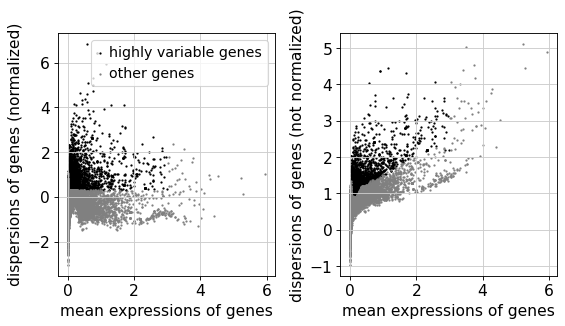

In [84]:
sc.pl.highly_variable_genes(adata)

In [85]:
print(np.sum(adata.var.highly_variable))

4105


In [86]:
adata = adata[:, adata.var.highly_variable].copy()

In [87]:
adata.write('./write/GSE153170_lognorm_hvg.h5ad')

# Preliminary processing

In [88]:
adata = sc.read('./write/GSE153170_lognorm_hvg.h5ad')

In [89]:
# normally regress out the top layers of unwanted effects
sc.pp.regress_out(adata, ['total_counts','n_genes_by_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'n_genes_by_counts', 'pct_counts_mt']
    finished (0:00:09)


In [90]:
# scale for pca
sc.pp.scale(adata)
# pca
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


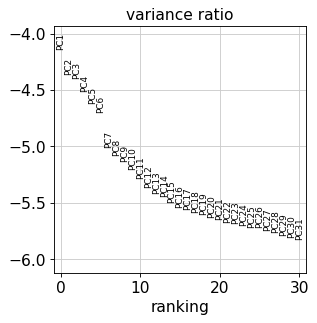

In [91]:
sc.pl.pca_variance_ratio(adata, log=True)

In [92]:
sc.pp.neighbors(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


In [93]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


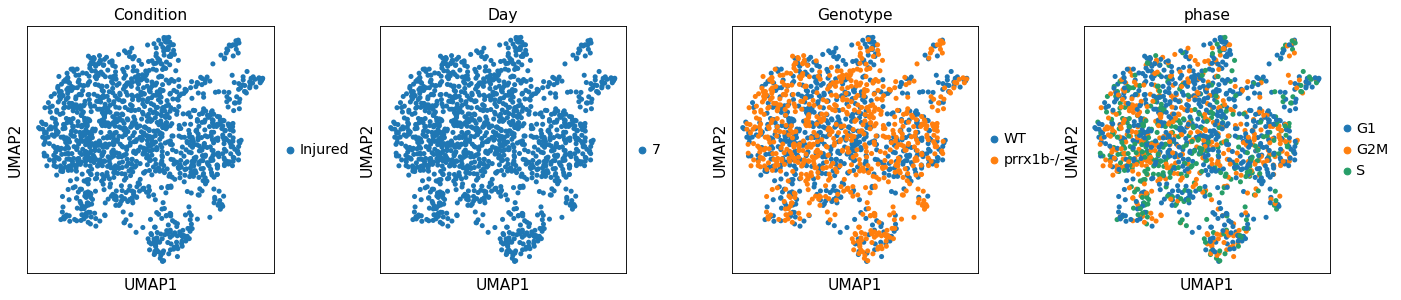

In [95]:
sc.pl.umap(adata, color= ['Condition', 'Day', 'Genotype', 'phase'], wspace=0.3)

In [96]:
adata.write('./write/GSE153170_processed.h5ad')

# Further modification